# 08. PyTorch Paper Replicating.

**The goal of machine learning research paper replicating is: turn a ML research paper into usuable code.**

In this notebook, I am going to be replicating the Vision Transformer (ViT) [architecture/paper](https://arxiv.org/abs/2010.11929) with PyTorch.


This notebook is fully followed from the greatest [course](https://zerotomastery.io/courses/learn-pytorch/) by [Daniel Bourke](https://www.linkedin.com/in/mrdbourke/)

The Book version of the course is [here](https://www.learnpytorch.io/08_pytorch_paper_replicating/)


# Get Setup

Now I am going to import the necessary libraries

In [86]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torchmetrics import Accuracy

try:
    from torchinfo import summary
except:
    print(f"[INFO] Couldn't find the torchinfo...\n Installing it.....")
    %pip install -qq torchinfo
    from torchinfo import summary

# Try to import going_moduler directory. download it from GitHub, if it doesn't work
try:
    print(f"[INFO] Trying to find the going_modular directory.....")
    from going_modular import data_setup, engine, utils
except:
    print(f"[INFO] Couldn't find the directory...\n Downloading it from github.....")
    !git clone https://github.com/Niloy009/learning_pytorch.git
    !mv leaning_pytorch/going_modular .
    !rm -rf learning_pytorch
    from going_modular import data_setup, engine, utils




[INFO] Trying to find the going_modular directory.....


In [2]:
# Setup device agnostic code

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

# Get the Data

Download the data if not exist and unzip it.

In [3]:
import os
from pathlib import Path
import zipfile
import requests

def download_data(source: str, destination: str, remove_source: bool= True) -> Path:
    """Download a ziped dataset from source and unzip to destination

    Args:
        source: The source path where the data will download from.
        destination: The destination path where the data will download and unzip to.
        remove_source: Whether the source remove or not after download.
        
    Returns:
        pathlib.Path to downloaded data.
    """

    # Setup the data path
    data_path = Path("data/")
    image_path = data_path / destination

    # If image folder is not exist, then prepare it and download the data
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping re-download")
    else:
        print(f"[INFO] {image_path} doesn't exist. Downloading it.....")
        image_path.mkdir(parents=True, exist_ok=True)

        # Download the data..
        target_file = Path(source).name
        with open(file=data_path / target_file , mode='wb') as file:
            request = requests.get(url=source)
            print(f"[INFO] Downloading {target_file} from {source}.....")
            file.write(request.content)
            
        # Unzip the folder
        with zipfile.ZipFile(data_path / target_file, mode='r') as zip_ref:
            print(f"[INFO] Unzipping {target_file} file......")
            zip_ref.extractall(path=image_path)

        # Remove the zip folder
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path


In [4]:
image_data_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip", 
              destination="pizza_steak_sushi")
image_data_path

[INFO] data/pizza_steak_sushi directory exists, skipping re-download


PosixPath('data/pizza_steak_sushi')

In [6]:
# Setup directory paths to train and test images
train_dir = image_data_path / 'train'
test_dir = image_data_path / 'test'

In [7]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

# Create Datasets and DataLoaders

In [8]:
# Create image size (from table 3 on ViT paper)
IMAGE_SIZE = 224

# Create transforms pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])
print(f"manually created transforms: {manual_transforms}")


manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [9]:
# Create batch size (the paper used 4096 but I am stick with 32 to start with small)
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=BATCH_SIZE)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

# Visualize a single image

In [32]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get the single image and label
image , label = image_batch[0], label_batch[0]

# Get the shape of the image and label
image.shape, label, image_batch.shape

(torch.Size([3, 224, 224]), tensor(1), torch.Size([32, 3, 224, 224]))

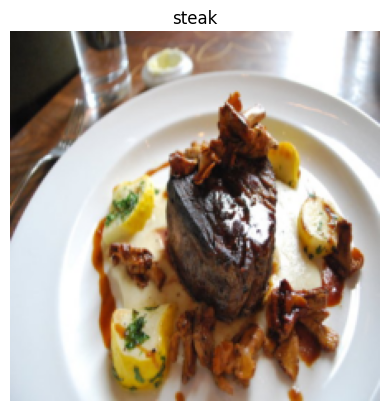

In [33]:
# Plot the image and its label
plt.imshow(image.permute(1,2,0)) # color_channel, height, width -> height, width, color_channel
plt.title(class_names[label])
plt.axis(False);


# Replicating ViT: Overview

Looking at a whole machine learning research paper can be imtimidating.

So in order to make it more understandable, we can break it down into smaller pieces:

* **Inputs** - What goes into the model? (in this case, image tensors)
* **Outputs** - What comes out of the model/layer/block? (in our case. we want the model to output image classification labels)
* **Layers** - Takes an input, manipulates it with a function. (i.e. could be self-attention)
* **Blocks** - A collection of layers
* **Model** - A collection of blocks

### ViT overview: pieces of the puzzle

* Figure 1: Visual overview of the architecture
* Four Equations: math equations which define the functions of eacher layer/block.
* Tabel 1/3: different hyperparameters for the architecture/training.
* Text Description (especially chapter 3.1 on paper)

#### Figure 1
![](./paper/images/Figure_1_model_architecture_edited.png)

* **Embedding:** Learnable representation (start with random number and improve over time)



#### Four Equations
![](./paper/images/Equations.png)

#### Section 3.1 Describes the various equations

**Equation 1:**

An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where ( $H, W$ ) is the resolution of the original image, $C$ is the number of channels, ( $P, P$ ) is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1 ). We refer to the output of this projection as the patch embeddings.

**Equation 1:**

Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

In pseudo code:
```python
# Equation 1
x_input = [class_token, image_patch_1, image_patch_2, ... image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ... image_patch_N_pos]
```


**Equation 2, 3:**

The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

In pseudo code:

```python
# Equation 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3
x_ouput_MLP_block = MLP_layer(Ln_layer(x_output_MSA_block)) + x_output_MSA_block
```


**Equation 4:**

Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches ( $\mathbf{z}_0^0=\mathbf{x}_{\text {class }}$ ), whose state at the output of the Transformer encoder ( $\mathbf{z}_L^0$ ) serves as the image representation $\mathbf{y}$ (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

* MLP: Multi Layer Preceptron -> a neural network with X number of layers.
* MLP: One hidden layer at **pre-training** time.
* MLP: Single linear layer at **fine-tuning** time.

In pseudo code:

```python
# Equation 4
y = Linear_layer(LN_layer(x_ouput_MLP_block))
```


#### Table 1
![](./paper/images/Table_1.png)

* ViT-Base, ViT-Large, ViT-Huge are all the same model architecture with different sizes.
* **ViT-B/16** - ViT-Base Model with patch size ${16\times16}$ 
* **Layers** - The number of transformer encode layers.
* **Hidden size $D$** - The embeding size throughout the architecture.
* **MLP size** - The number of hidden units/neurons in the MLP.
* **Heads** - The number of multi-head self-attention.

 ## 4. Equation 1: Split data into patches and creating the class, position and patch embedding.

 First I want to know what is my input shape and output shape:

 * Input Shape: ${H \times W \times C}$ -> Height, Width, Color Channels
 * Output Shape: ${N \times (P^2 \cdot C)}$
 * H: Height
 * W: Width
 * C: Color Channel
 * P: Patch Size
 * N: Number of Patch Size -> ${(Height \times Width) / P^2}$
 * D: Constant latent vector size -> **embedding dimension** (see table 1)

In [12]:
# Create Examples
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate number of patches
num_patches = int((height * width) / (patch_size ** 2))
print(f"Number of patches: {num_patches}")

Number of patches: 196


In [13]:
# Input Shape
embedding_layer_input_shape = (height, width, color_channels)

# Output Shape
embedding_layer_output_shape = (num_patches, patch_size **2 * color_channels)

print(f"Input Shape (Single 2D Image): {embedding_layer_input_shape}")
print(f"Output Shape (Single 1D sequence of patches): {embedding_layer_output_shape}")

Input Shape (Single 2D Image): (224, 224, 3)
Output Shape (Single 1D sequence of patches): (196, 768)


### 4.1 Turning a single image into patches

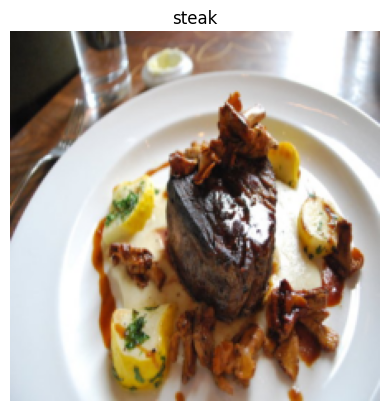

In [34]:
# Visualize a single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

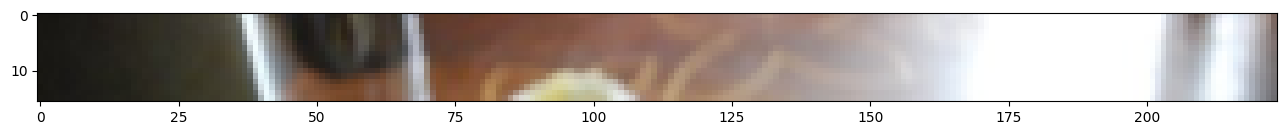

In [36]:
# Change image shape to be compatible with matplotlib
image_permuted = image.permute(1,2,0) # color_channel, height, width -> height, width, color_channel

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size)) 
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0 
Patch size: 16 pxls x 16 pxls


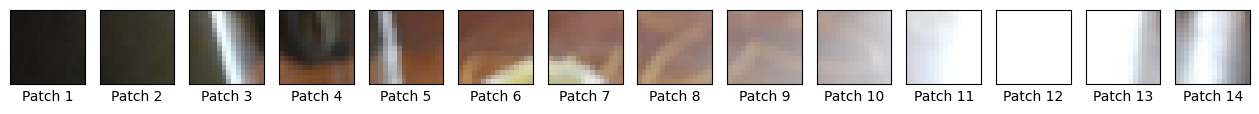

In [37]:
# Setup code to plot the top row as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches} \nPatch size: {patch_size} pxls x {patch_size} pxls")

# Create subplots
fig,axs = plt.subplots(nrows=1,
                    ncols= img_size // patch_size, # one column per patch
                    figsize=(patch_size, patch_size),
                    sharex=True,
                    sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[0:patch_size, patch:patch+patch_size, :]) # plot the patch
    axs[i].set_xlabel(f"Patch {i+1}") # set the xlabel
    axs[i].set_xticks([]) # remove x ticks
    axs[i].set_yticks([]) # remove y ticks

Number of patches per row: 14.0    
Number of patches per column: 14.0    
Total Patches: 196.0    
Patch size: 16 pxls x 16 pxls


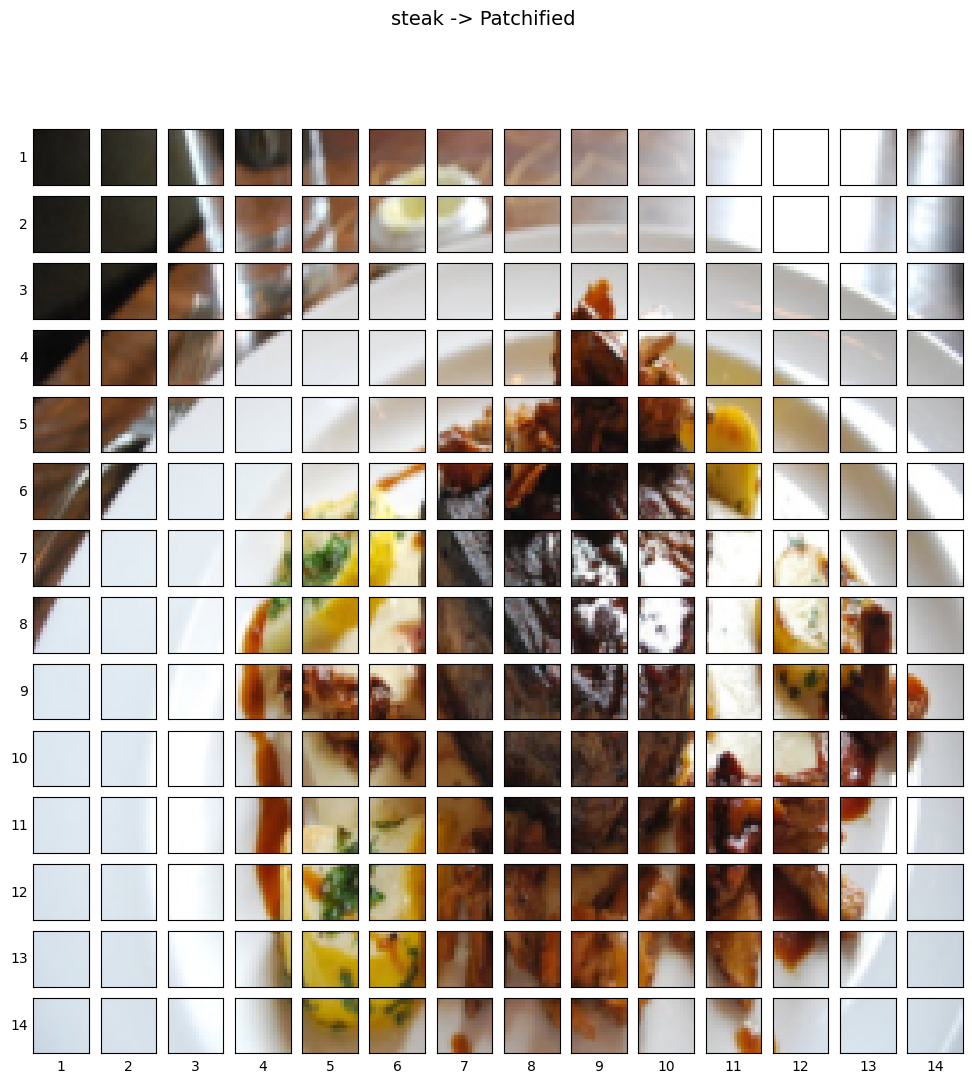

In [38]:
# Setup code to plot the whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
    \nNumber of patches per column: {num_patches}\
    \nTotal Patches: {num_patches * num_patches}\
    \nPatch size: {patch_size} pxls x {patch_size} pxls")

# Create subplots
fig,axs = plt.subplots(nrows= img_size // patch_size,
                    ncols= img_size // patch_size, # one column per patch
                    figsize=(12, 12),
                    sharex=True,
                    sharey=True)

# Loop through height and width of the image and plot patches
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        # Plot the permuted image in different axes
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, #iterate through height
                                        patch_width:patch_width+patch_size, #iterate through width
                                        : ]) # all color channels
        # Setup label information for each subplots (patch)
        axs[i, j].set_ylabel(i+1, rotation="horizontal", horizontalalignment='right', verticalalignment='center')
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([]) # remove x ticks
        axs[i, j].set_yticks([]) # remove y ticks
        axs[i, j].label_outer() # only show outer labels
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)
plt.show()

### 4.2 Creating image patches and turn them into patch embeddings

Though I could make the image patches via `matplotlib`. Now I can create image patches and patch embedding in one step by using `torch.nn.Conv2d()` and set the kernel size and the stride to `patch_size`.

In [39]:
# Create conv2d layer to turn the image into patchees of leranable patch embeddings

# Set the patch size
patch_size = 16

# Create a conv2d layer by using the parameters mentioned in the ViT paper
conv2d_layer = nn.Conv2d(in_channels=3, # color channels
                         out_channels=768, # embedding dimension
                         kernel_size=patch_size, 
                         stride=patch_size,
                         padding=0
                         ) 

conv2d_layer

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

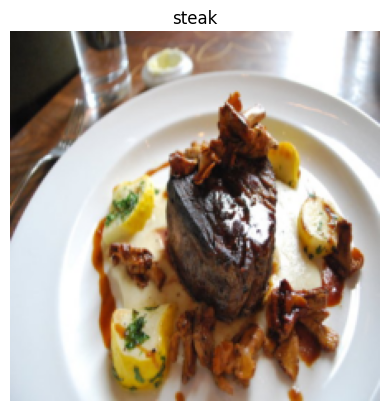

In [40]:
# Visualize a single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [41]:
# Pass the image through the conv2d layer
img_out_conv2d = conv2d_layer(image.unsqueeze(0)) # add batch dimension

# Check out the shape of the conv2d output
img_out_conv2d.shape

torch.Size([1, 768, 14, 14])

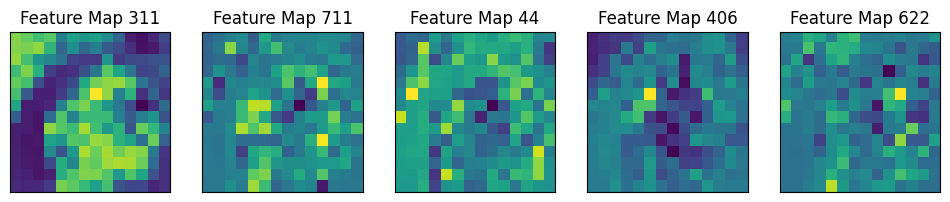

In [68]:
# Plot the random convulational features map (embeddings)
import random
random_idx = random.sample(range(0,768), k=5) # select 5 random indices

# Create subplots
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot the random convulational features map (embeddings)
for i, idx in enumerate(random_idx):
    img_conv_feat_map = img_out_conv2d[0, idx, :, :].detach().numpy() # get the feature map and convert to numpy array
    axs[i].imshow(img_conv_feat_map)
    axs[i].set(title=f"Feature Map {idx}", xticks=[], yticks=[], xticklabels=[], yticklabels=[]);


### 4.3 Flattening the patch embedding with `torch.nn.Flatten()`

Right now I have series of convolutional features map (patch embeddings) that i want to flatten into a sequence of patch embeddings to fullfill the input criteria of the ViT encoder.

In [69]:
print(f"Conv2d output shape: {img_out_conv2d.shape}") # (batch_size, embedding_dim, feat_map_height, feat_map_width)

Conv2d output shape: torch.Size([1, 768, 14, 14])


In [70]:
# Flatten Layer
flatten_layer = nn.Flatten(start_dim=2, end_dim=3)

# Pass the conv feature maps through the flatten layer
img_out_flatten = flatten_layer(img_out_conv2d)

print(f"The Shape after the Flatten Layer: {img_out_flatten.shape} -> [batch_size, embedding_dim, num_patches]")

The Shape after the Flatten Layer: torch.Size([1, 768, 196]) -> [batch_size, embedding_dim, num_patches]


The shape of orginal image: torch.Size([3, 224, 224])
Shape after Conv2d layer: torch.Size([1, 768, 14, 14])
The Shape after the Flatten Layer: torch.Size([1, 768, 196])
The final output shape: torch.Size([1, 196, 768])


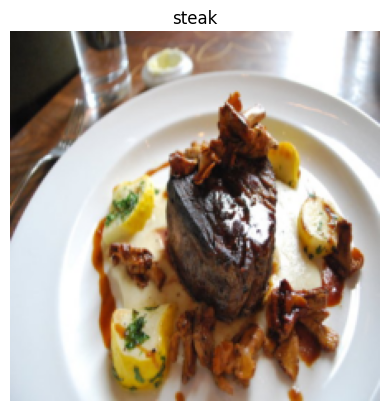

In [ ]:
# Put everything together

# Show the single image and shape
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

print(f"The shape of orginal image: {image.shape}")

# Turn image into feature maps (patch embeddings) via conv2d layer
img_out_conv2d = conv2d_layer(image.unsqueeze(0)) # add batch dimension
print(f"Shape after Conv2d layer: {img_out_conv2d.shape}") # [batch_size, embedding_dim, feat_map_height, feat_map_width]

# Flatten the conv feature maps into sequence of patch embeddings
img_out_flatten = flatten_layer(img_out_conv2d)
print(f"The Shape after the Flatten Layer: {img_out_flatten.shape}") # [batch_size, embedding_dim, num_patches]

# Rearrange the flattened output
img_flatten_out_permuted = img_out_flatten.permute(0, 2, 1) # batch_size, num_patches, embedding_dim
print(f"The final output shape: {img_flatten_out_permuted.shape}") # [batch_size, num_patches (N), embedding_dim]

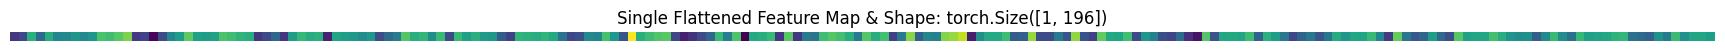

In [83]:
# Get a single feature map
single_flattened_feature_map = img_flatten_out_permuted[:, :, 0]

# Plot the single feature map
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Single Flattened Feature Map & Shape: {single_flattened_feature_map.shape}")
plt.axis(False);


### 4.4 Turning the ViT patch embedding layer into a PyTorch module

I want this module to do a few things:
1. Create a class called `PatchEmbedding` that inherits from `nn.Module`.
2. Initialize with appropriate hyperparameters, such as channels, embedding dimension, patch size.
3. Create a layer to turn an image into embedding patched using `nn.Conv2d()`.
4. Create a layer to flatten the feature maps of the output of the layer in 3.
5. Define a `forward()` that defines the forward computation (e.g. pass through layer from 3 & 4).
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding.

In [84]:
# 1. Create a class called PatchEmbedding
class PatchEmbedding(nn.Module):
    # 2. Initialize the layer with approproiate hyperparameters
    def __init__(self, 
                in_channels: int=3,
                patch_size: int=16,
                embedding_dim: int=768): # from Table 1 (ViT paper) for Vit-Base
        super().__init__()
        
        # 3. Create a layer to turn an image into patches of learnable patch embeddings
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                out_channels=embedding_dim,
                                kernel_size=patch_size,
                                stride=patch_size,
                                padding=0)
        
        # 4. Create a flatten layer to flatten the conv feature maps
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        
    # 5. Define a forward method to pass data through the layers
    def forward(self, x):
        # Create a assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Image size must be divisible by patch size. Got image shape: {image_resolution} and patch size: {patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x) # turn image into patches via conv2d layer
        x_flattened = self.flatten(x_patched) # flatten the conv feature maps
        
        # 6. Rearrange the flattened output
        return x_flattened.permute(0, 2, 1) # batch_size, num_patches, embedding_dim

In [94]:
# Set seeds
utils.set_seeds()

# Create an instance of the PatchEmbedding class
patchify = PatchEmbedding(in_channels=3, patch_size=16, embedding_dim=768)

# pass a single image through the patch embedding layer
print(f"Input image shape: {image.unsqueeze(0).shape}") # add batch dimension
patch_embedded_img = patchify(image.unsqueeze(0))
print(f"Patch embedded image shape: {patch_embedded_img.shape}") # [batch_size, num_patches, embedding_dim]

Input image shape: torch.Size([1, 3, 224, 224])
Patch embedded image shape: torch.Size([1, 196, 768])


In [97]:
patch_embedded_img

tensor([[[-0.1443,  0.0320, -0.0579,  ...,  0.0952, -0.0609,  0.0285],
         [-0.2355,  0.0640, -0.0620,  ...,  0.1590, -0.1056,  0.0504],
         [-0.5025,  0.1220, -0.2413,  ...,  0.4650, -0.1632,  0.0701],
         ...,
         [-0.8451,  0.2403, -0.2837,  ...,  0.6411, -0.3563,  0.3110],
         [-0.8865,  0.2598, -0.2761,  ...,  0.7044, -0.4130,  0.3168],
         [-0.8399,  0.2564, -0.2774,  ...,  0.6904, -0.3912,  0.3140]]],
       grad_fn=<PermuteBackward0>)

In [95]:
rand_img_tensor = torch.randn(size=(1, 3, 224, 224)) # batch_size, color_channels, height, width
rand_img_tensor_bad = torch.randn(size=(1, 3, 250, 250)) # batch_size, color_channels, height, width
# patchify(rand_img_tensor_bad)

### 4.5 Creating the class token embedding

Want to: prepend a learnable class token to the start of the patch embedding

In [99]:
patch_embedded_img

tensor([[[-0.1443,  0.0320, -0.0579,  ...,  0.0952, -0.0609,  0.0285],
         [-0.2355,  0.0640, -0.0620,  ...,  0.1590, -0.1056,  0.0504],
         [-0.5025,  0.1220, -0.2413,  ...,  0.4650, -0.1632,  0.0701],
         ...,
         [-0.8451,  0.2403, -0.2837,  ...,  0.6411, -0.3563,  0.3110],
         [-0.8865,  0.2598, -0.2761,  ...,  0.7044, -0.4130,  0.3168],
         [-0.8399,  0.2564, -0.2774,  ...,  0.6904, -0.3912,  0.3140]]],
       grad_fn=<PermuteBackward0>)

In [103]:
# Get the batch size and the embedding dimension
batch_size, num_patches, embedding_dim = patch_embedded_img.shape
batch_size, embedding_dim

(1, 768)

In [107]:
# Create class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dim), requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [117]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_img_with_class_token = torch.cat((class_token, patch_embedded_img), dim=1)
print(patch_embedded_img_with_class_token)
print(f"Sequence of patch embedding  {patch_embedded_img_with_class_token.shape} -> [batch_size, class_token+num_patches, embedding_dim]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.1443,  0.0320, -0.0579,  ...,  0.0952, -0.0609,  0.0285],
         [-0.2355,  0.0640, -0.0620,  ...,  0.1590, -0.1056,  0.0504],
         ...,
         [-0.8451,  0.2403, -0.2837,  ...,  0.6411, -0.3563,  0.3110],
         [-0.8865,  0.2598, -0.2761,  ...,  0.7044, -0.4130,  0.3168],
         [-0.8399,  0.2564, -0.2774,  ...,  0.6904, -0.3912,  0.3140]]],
       grad_fn=<CatBackward0>)
Sequence of patch embedding  torch.Size([1, 197, 768]) -> [batch_size, class_token+num_patches, embedding_dim]


### 4.6 Creating the position embedding

Want to: create a series of 1D learnable position embedding and to add them to the sequence of patch embeddings

In [118]:
# View the sequence of patch embeddings with the class token
patch_embedded_img_with_class_token, patch_embedded_img_with_class_token.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.1443,  0.0320, -0.0579,  ...,  0.0952, -0.0609,  0.0285],
          [-0.2355,  0.0640, -0.0620,  ...,  0.1590, -0.1056,  0.0504],
          ...,
          [-0.8451,  0.2403, -0.2837,  ...,  0.6411, -0.3563,  0.3110],
          [-0.8865,  0.2598, -0.2761,  ...,  0.7044, -0.4130,  0.3168],
          [-0.8399,  0.2564, -0.2774,  ...,  0.6904, -0.3912,  0.3140]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [120]:
# Calculate the number of patches
number_of_patches = int((height * width) / (patch_size ** 2))

# Get the embedding dimension
embedding_dim = patch_embedded_img_with_class_token.shape[-1]

number_of_patches, embedding_dim

(196, 768)

In [121]:
# Create a learnable position embedding
position_embedding = nn.Parameter(torch.ones(1, number_of_patches + 1, embedding_dim), requires_grad=True)

position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [122]:
# Add the position embedding to the patch embeddings with class token
patch_with_pos_embedding = patch_embedded_img_with_class_token + position_embedding

patch_with_pos_embedding, patch_with_pos_embedding.shape

(tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [0.8557, 1.0320, 0.9421,  ..., 1.0952, 0.9391, 1.0285],
          [0.7645, 1.0640, 0.9380,  ..., 1.1590, 0.8944, 1.0504],
          ...,
          [0.1549, 1.2403, 0.7163,  ..., 1.6411, 0.6437, 1.3110],
          [0.1135, 1.2598, 0.7239,  ..., 1.7044, 0.5870, 1.3168],
          [0.1601, 1.2564, 0.7226,  ..., 1.6904, 0.6088, 1.3140]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

### 4.7 Putting it all together: from image to embedding

I've written code to turn into a flattened sequence of patch embeddings. Now I make it all in one cell.

In [129]:
# Set seeds
utils.set_seeds()

# 1. Set the patch size
patch_size = 16

# 2. Print the shape of the orginal image tensor and get the image dimension
print(f"Original image tensor shape: {image.shape}") # [color_channels, height, width]
_, img_height, img_width = image.shape

# 3. Get image tensor and add batch dimenssion
x = image.unsqueeze(0)
print(f"Input image with batch dimenssion shape: {x.shape}") # [batch_size, color_channels, height, width]

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3, patch_size=patch_size, embedding_dim=768)

# 5. Pass the image through the patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedded image shape: {patch_embedding.shape}") # [batch_size, num_patches, embedding_dim]

# 6. Create class token embedding
batch_size, num_patches, embedding_dim = patch_embedding.shape
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dim), requires_grad=True) # make sure it's learnasble
print(f"Class token embedding shape: {class_token.shape}") # [batch_size, 1, embedding_dim]

# 7. Add the class token embedding to the front of the patch embeddings
patch_embedding_with_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embeddings with class token shape: {patch_embedding_with_class_token.shape}") # [batch_size, num_patches+1, embedding_dim]

# 8. Create position embedding
number_of_patches = int((img_height * img_width) / (patch_size ** 2))
position_embedding = nn.Parameter(torch.ones(1, number_of_patches + 1, embedding_dim), requires_grad=True) # make sure it's learnasble
print(f"Position embedding shape: {position_embedding.shape}") # [1, num_patches+1, embedding_dim]

# 9. Add the position embedding to the patch embedding with class token embedding
patch_embedding_with_pos_embedding = patch_embedding_with_class_token + position_embedding
print(f"Patch embeddings with position embedding shape: {patch_embedding_with_pos_embedding.shape}") # [batch_size, num_patches+1, embedding_dim]

Original image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimenssion shape: torch.Size([1, 3, 224, 224])
Patch embedded image shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embeddings with class token shape: torch.Size([1, 197, 768])
Position embedding shape: torch.Size([1, 197, 768])
Patch embeddings with position embedding shape: torch.Size([1, 197, 768])
